In [298]:
import numpy as np
import torch
import torchvision
from torch import nn
from tqdm.notebook import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [299]:
# Load the data
train_data = torchvision.datasets.MNIST(root='/data', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='/data', train=False, download=True, transform=torchvision.transforms.ToTensor())

# Create the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [300]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([64, 1, 28, 28])

In [301]:
class DigitRecognizer(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=0),
                nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(16)
        )
        
        self.Classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 10)
        )
                    
    def forward(self, x):
        return self.Classifier(self.conv_block(x))
    
    def probabilities(self, x):
        with torch.no_grad():
            return torch.softmax(self.forward(x), dim=1)
    
    def predict(self, x, is_batch=False):
        if not is_batch:    
            # Add a dimension for the batch
            x = x.unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.forward(x), dim=1)

In [302]:
model = DigitRecognizer()

In [303]:
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DigitRecognizer                          [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 16, 26, 26]           160
│    └─ReLU: 2-2                         [1, 16, 26, 26]           --
│    └─MaxPool2d: 2-3                    [1, 16, 13, 13]           --
│    └─Conv2d: 2-4                       [1, 16, 11, 11]           2,320
│    └─ReLU: 2-5                         [1, 16, 11, 11]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
│    └─BatchNorm2d: 2-7                  [1, 16, 5, 5]             32
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-8                      [1, 400]                  --
│    └─Linear: 2-9                       [1, 10]                   4,010
Total params: 6,522
Trainable params: 6,522
Non-trainable params: 0
Total mult

In [304]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [305]:
# Train the model
EPOCHS = 2
model.to(device)
losses = []
for epoch in range(EPOCHS):
    
    running_loss = 0
    running_accuracy = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        # Move the images and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)
        
        # Calculate the loss
        loss = loss_fn(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        running_loss += loss.item()
        running_accuracy += torch.sum(torch.argmax(output, dim=1) == labels).item()
    losses.append(running_loss/len(train_loader))
    print(f"Training loss: {running_loss/len(train_loader)}")
    print(f"Training accuracy: {100*running_accuracy/len(train_data)}%")

Epoch 1/2:   0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.18715300749359862
Training accuracy: 95.02%


Epoch 2/2:   0%|          | 0/938 [00:00<?, ?it/s]

Training loss: 0.05546869591599815
Training accuracy: 98.33333333333333%


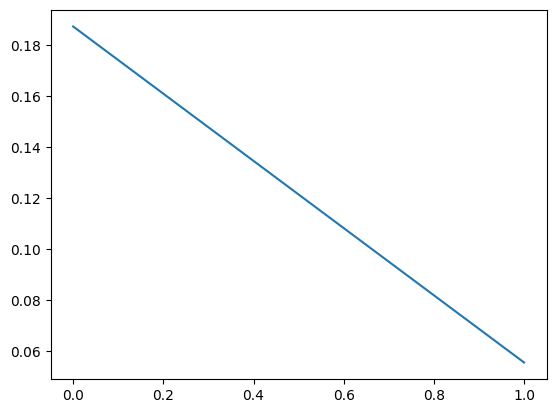

In [306]:
plt.plot(losses)

In [307]:
# Test the model
model.to(device)
wrong_predictions = []
# Turn off gradients
with torch.no_grad():
        
        model.eval() # Batchnorm and dropout layers will change their behaviour
        
        total_correct = 0
        for image, label in tqdm(test_data, desc="Testing"):
            image = image.to(device)
            
            # Forward pass
            output = model.predict(image)

            total_correct += (output == label).item()
            if output != label:
                wrong_predictions.append((image, output, label))
        print(f"Test accuracy: {100*total_correct/len(test_data)}%")

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Test accuracy: 98.49%


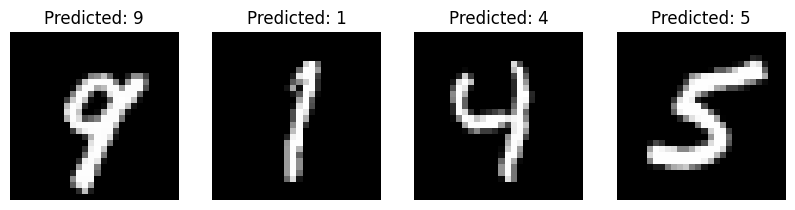

In [308]:
# Compare the predictions with the images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass
output_label = model.predict(images, is_batch=True)

# Plot the images
fig, axes = plt.subplots(figsize=(10, 4), ncols=4)
for i in range(4):
    ax = axes[i]
    ax.imshow(images[i].view(28, 28).cpu(), cmap='gray')
    ax.set_title(f"Predicted: {output_label[i].item()}")
    ax.axis('off')

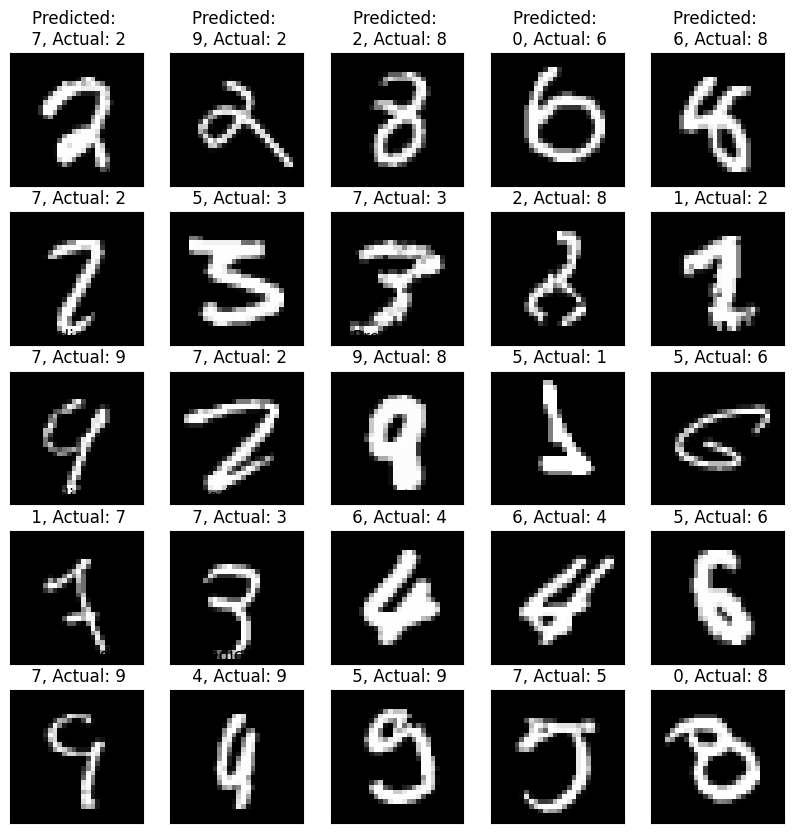

In [309]:
# Plot the wrong predictions
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, output, label) in enumerate(wrong_predictions[:25]):
    axes[i//5, i%5].imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
    axes[i//5, i%5].set_title(f"Predicted: \n {output.item()}, Actual: {label}")
    axes[i//5, i%5].set_xticks([])
    axes[i//5, i%5].set_yticks([])

In [310]:
# Save the model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_mnist_CNN.pt"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)